<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2023/blob/main/Tutorial_6_Tuning_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dr. Daugherity, PHYS 453

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tutorial 6 - Tuning and Evaluation


We've already discussed some binary classification metrics in class and have played with evaluating mystery classifiers using the built-in reports: 
* User's Guide: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
* Classification Report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
* [Classifier Challenge](https://github.com/mdaugherity/MachineLearning2022/blob/main/Class/Class_1_28_2022_Classifier_Challenge.ipynb)
 
Now we make this approach more official and see how to properly tune and evaluate classifiers.  Remember, the goal is to finish the overview of classification problems before we dive in to seeing how more classifiers actually work.



# Test/Train Split
Our primary issue is how to fairly evaluate a classifier so we can avoid under/over-fitting and tune parameters. The key concept is to split the dataset and save a fraction as our "test" data that we **DO NOT FIT THE CLASSIFIER** with.

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=500>

**Reference**
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* https://scikit-learn.org/stable/modules/cross_validation.html  (figure source)

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## Random State
Before we begin, it is important to understand how ```random_state``` works.  In a nutshell, there is no such thing as a random number in computing.  All random numbers are generated from a seed, and the same algorithm with the same seed produces the same list of numbers.  It is sometimes convenient to get set the seed with ```random_state``` to get the same results while you are working.  Common values are 0,1, 42, or other sci-fi / pop-culture references.  

A good analogy is to think about a book filled with numbers.  Setting random_state tells the program which page of the book to use.  

For more detail, read section 10.3 in https://scikit-learn.org/stable/common_pitfalls.html

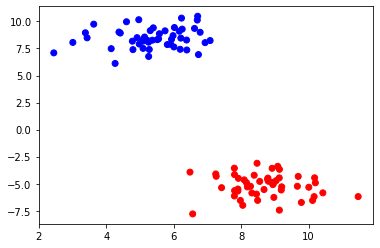

In [3]:
# Run this with and without random_state
#X,y = make_blobs(centers=2, random_state=0)
X,y = make_blobs(centers=2)

plt.scatter(X[:,0], X[:,1],c=y,cmap='bwr')
plt.show()

(100,) (80,) (20,)


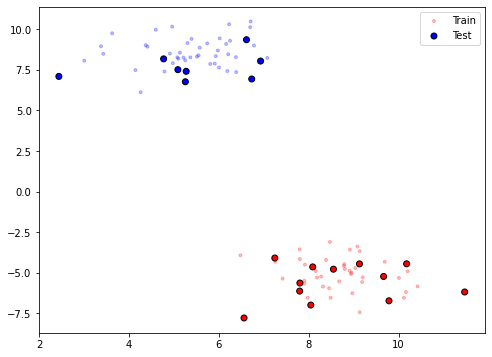

In [4]:
# Run this with and without random_state
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(y.shape, y_train.shape, y_test.shape)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1],marker='.',c=y_train,cmap='bwr',label='Train', alpha=0.25)
plt.scatter(X_test[:,0], X_test[:,1],marker='o',edgecolor='k',c=y_test,cmap='bwr',label='Test')
plt.legend()

plt.show()

# Choosing the right values (tuning parameters)
Essentially all classifiers have parameters you can tune to improve performance.  For example, how do we choose k for kNearestNeighbors?

In [5]:
from sklearn import datasets
from sklearn import neighbors
from sklearn import model_selection

In [6]:
data = datasets.load_iris()
print('Features:\t',data.feature_names)
print('Targets:\t',data.target_names)

X = data.data
y = data.target

Features:	 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:	 ['setosa' 'versicolor' 'virginica']


In [7]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)   # how many to pick?

# Example 1 - Test/Train Split 
We'll start by doing things the hard way for transparency.  The basic approach is:
1.  Split the data into testing and training sets
1.  Call ```fit``` on training data
1.  Score the classifier on the testing data 
1.  Use brutal force to try lots of options and pick the best one

Play with this code below.  Notice how the results depend on test_size and can be VERY sensitive on random_state.


(569, 30)


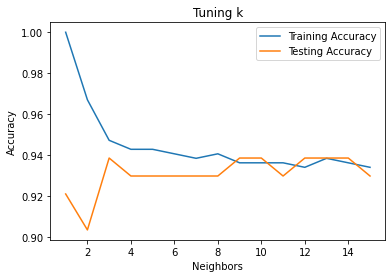

In [8]:
#data = datasets.load_iris()
data = datasets.load_breast_cancer()
X = data.data
y = data.target

# Run this with and without random_state
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)#random_state=1)
print(X.shape)

KLIST = np.arange(1,16)

train_scores = []
test_scores = []
for k in KLIST:
  clf = neighbors.KNeighborsClassifier(n_neighbors=k)
  clf.fit(X_train,y_train)
  
  test_score = clf.score(X_test,y_test)
  train_score = clf.score(X_train,y_train)
  #print(k, train_score, test_score)
  train_scores.append(train_score)
  test_scores.append(test_score)

plt.plot(KLIST, train_scores, label='Training Accuracy')
plt.plot(KLIST, test_scores, label='Testing Accuracy')
plt.legend()
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.title('Tuning k')
plt.show()

# Example 2 - Cross Valildation Grid Search

A great way to get more consistent results is to use **cross validation**.  We do the process 5 times and average over the results to ensure that the entire training data set gets used.

As always, we DO NOT PEEK at the test data until we have completely finalized our classifier.

<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' width=500>

In this example below, we'll see how cross validation gives more stable results than the previous example.

**References:**
* https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV





In [9]:
# Quick demo: see how cross_val_score returns a score for each "fold"
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train,y_train)
model_selection.cross_val_score(clf,X_train,y_train)

array([0.9010989 , 0.89010989, 0.91208791, 0.95604396, 0.93406593])

In [15]:
#data = datasets.load_breast_cancer()
data = datasets.load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)  #random_state=1)
#print(X.shape)

# Set up parameters to try
KLIST = np.arange(1,16)
params = {'n_neighbors':KLIST}
print('Parameters to try:',params)

grid_clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=params)
grid_clf.fit(X,y)

print('Best estimator:', grid_clf.best_estimator_)
print('Best parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Parameters to try: {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}
Best estimator: KNeighborsClassifier(n_neighbors=6)
Best parameters: {'n_neighbors': 6}
Best score: 0.9800000000000001


## Diving In
The above example shows how quick and easy it is to get a result using GridSearchCV.  Below are totally unnecesary examples of how to dive in to the search results and see what happened. 

In [16]:
# Wow, look at all of this
grid_clf.cv_results_

{'mean_fit_time': array([0.00077038, 0.00058212, 0.00058093, 0.00058026, 0.00053544,
        0.0005281 , 0.00070686, 0.0005147 , 0.00059152, 0.00054164,
        0.00055442, 0.00053048, 0.0005517 , 0.00051789, 0.00063992]),
 'std_fit_time': array([2.61872152e-04, 2.45140680e-05, 1.01367393e-04, 7.00287603e-05,
        2.06638360e-05, 1.09309133e-05, 1.54589651e-04, 1.67038718e-05,
        1.09355302e-04, 1.75592653e-05, 3.44927007e-05, 1.46358717e-05,
        3.01204864e-05, 1.06243770e-05, 1.75785422e-04]),
 'mean_score_time': array([0.00193787, 0.00176535, 0.00195541, 0.00168943, 0.00165505,
        0.00163698, 0.00186939, 0.00166717, 0.0016335 , 0.00162249,
        0.00183868, 0.00167646, 0.00176201, 0.00161018, 0.00274758]),
 'std_score_time': array([1.31067348e-04, 1.90937804e-04, 3.69853897e-04, 6.88654226e-05,
        7.92851871e-05, 9.30733122e-05, 2.01953310e-04, 9.49991506e-05,
        7.38615371e-05, 3.43509464e-05, 1.61975975e-04, 1.05724982e-04,
        1.47720858e-04, 9.58

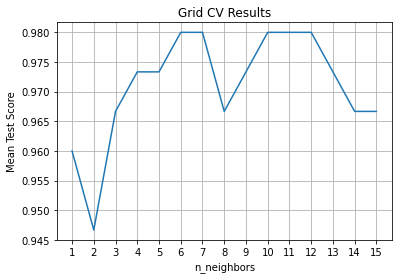

In [37]:
# Plot the results
res = grid_clf.cv_results_
#print(res['mean_test_score'])

plt.plot(KLIST,res['mean_test_score'])
plt.title('Grid CV Results')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Test Score')
plt.xticks(ticks=KLIST, labels=KLIST)
plt.grid()
plt.show()

# Conclusion
* Use a test/train split to evaulate your classifier.  
* Do a CV Grid Search on the training data to tune parameters